In [111]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit import ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [112]:
# runtime imports
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)

In [113]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import QasmSimulator, AerSimulator

backend = QasmSimulator()

In [114]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
# )

hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980)]
)

print(hamiltonian)

SparsePauliOp(['YZ'],
              coeffs=[0.398+0.j])


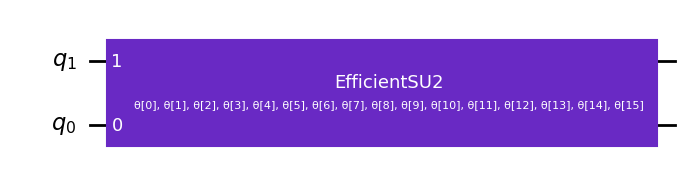

In [115]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw()

In [116]:
num_params = ansatz.num_parameters

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [117]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [118]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    if cost_history_dict['iters'] == 0:    
        ansatz.h(0)
        ansatz.sdg(0)
        ansatz.cx(0,1)
        cr = ClassicalRegister(1, name='cr')
        ansatz.add_register(cr)
        ansatz.measure(1,0)
    
    # print(cost_history_dict['iters'])
    # print(ansatz)
    sampler = SamplerV2(backend=AerSimulator())

    job = sampler.run([(ansatz, params, 1000)])
    counts = job.result()[0].data.cr.get_counts()
    print(counts)
    total = sum(counts.values())
    print(total)
    probabilities = { state: count/total for state, count in counts.items() }
    print(probabilities)
    energy = (probabilities['0'] - probabilities['1'])*0.3980
    print(energy)

    # pub = (ansatz, [hamiltonian], [params])
    # result = estimator.run(pubs=[pub]).result()
    # energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [119]:
x0 = 2 * np.pi * np.random.random(num_params)

In [120]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

{'1': 257, '0': 743}
1000
{'1': 0.257, '0': 0.743}
0.19342800000000002
Iters. done: 1 [Current cost: 0.19342800000000002]
{'0': 797, '1': 203}
1000
{'0': 0.797, '1': 0.203}
0.23641200000000004
Iters. done: 2 [Current cost: 0.23641200000000004]
{'0': 579, '1': 421}
1000
{'0': 0.579, '1': 0.421}
0.062884
Iters. done: 3 [Current cost: 0.062884]
{'0': 579, '1': 421}
1000
{'0': 0.579, '1': 0.421}
0.062884
Iters. done: 4 [Current cost: 0.062884]
{'0': 775, '1': 225}
1000
{'0': 0.775, '1': 0.225}
0.21890000000000004
Iters. done: 5 [Current cost: 0.21890000000000004]
{'0': 470, '1': 530}
1000
{'0': 0.47, '1': 0.53}
-0.023880000000000023
Iters. done: 6 [Current cost: -0.023880000000000023]
{'1': 649, '0': 351}
1000
{'1': 0.649, '0': 0.351}
-0.11860400000000003
Iters. done: 7 [Current cost: -0.11860400000000003]
{'0': 466, '1': 534}
1000
{'0': 0.466, '1': 0.534}
-0.027064000000000005
Iters. done: 8 [Current cost: -0.027064000000000005]
{'0': 211, '1': 789}
1000
{'0': 0.211, '1': 0.789}
-0.230044

In [121]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.39163200000000004
       x: [ 3.228e+00  4.617e+00 ...  3.108e+00  6.223e+00]
    nfev: 155
   maxcv: 0.0


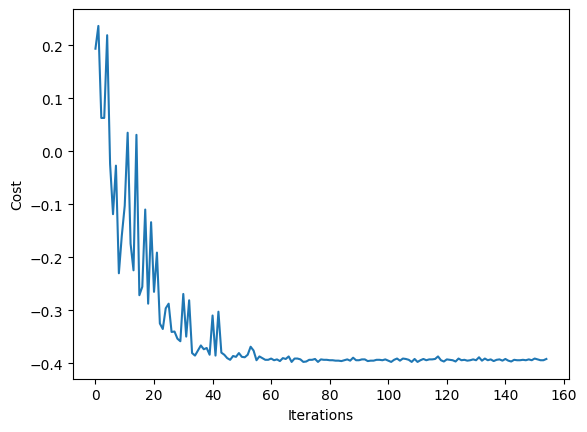

In [122]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()